## Describing EMS & Fire Data

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()

True

In [110]:
ems_example_df = pd.read_csv(os.getenv('EMS_DATA_EXAMPLE_PATH'))
fire_example_df = pd.read_csv(os.getenv('FIRE_DATA_EXAMPLE_PATH'))


print(f"EMS DataFrame shape: {ems_example_df.shape}")
print(f"Fire DataFrame shape: {fire_example_df.shape}")

EMS DataFrame shape: (2369, 11)
Fire DataFrame shape: (6350, 28)


#### Average Response Time

Top 5 Incident Types:
Basic Incident Type (FD1.21)
Outside equipment fire                              21.566667
Search for person on land                           15.296726
Brush or brush-and-grass mixture fire (Wildland)    13.733333
Carbon monoxide incident                            13.179365
Sprinkler activation, no fire - unintentional       12.191667
Name: resp_mins, dtype: float64


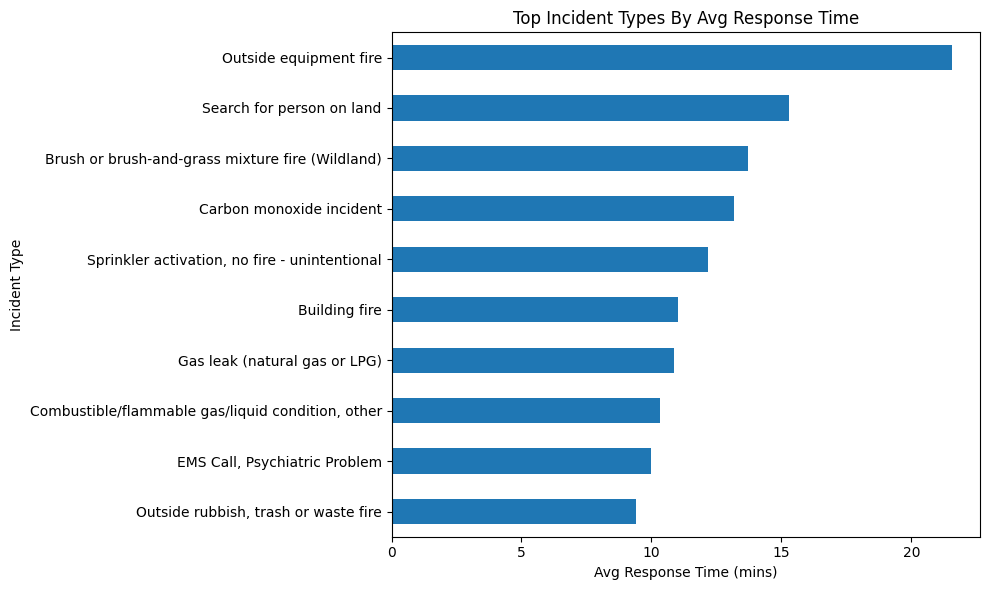

In [111]:
fire_example_df["dispatch_time"] = pd.to_datetime(fire_example_df["Apparatus Resource Dispatch Date Time (FD18.3)"], errors="coerce")
fire_example_df["arrive_time"] = pd.to_datetime(fire_example_df["Apparatus Resource Arrival Date Time (FD18.4)"], errors="coerce")

fire_example_df["resp_mins"] = (fire_example_df["arrive_time"] - fire_example_df["dispatch_time"]).dt.total_seconds() / 60

res = (
    fire_example_df.groupby("Basic Incident Type (FD1.21)")["resp_mins"]
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

print("Top 5 Incident Types:")
print(res.head())

plt.figure(figsize=(10,6))
res.head(10).plot(kind="barh")
plt.xlabel("Avg Response Time (mins)")
plt.ylabel("Incident Type")
plt.title("Top Incident Types By Avg Response Time")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Incidents By Week

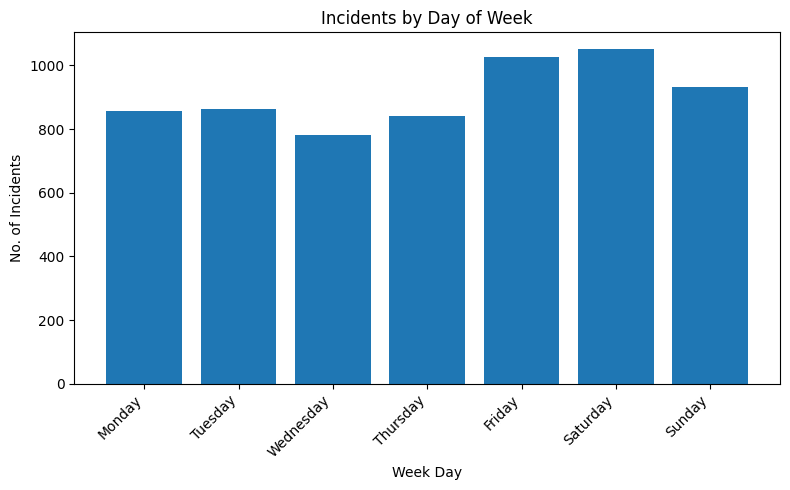

In [112]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day_stats = (fire_example_df["Basic Incident Day Name (FD1.3)"].value_counts().reindex(days_of_week, fill_value=0))

plt.figure(figsize=(8, 5))
plt.bar(day_stats.index, day_stats.values)
plt.xlabel("Week Day")
plt.ylabel("No. of Incidents")
plt.title("Incidents by Day of Week")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Resource Utilization


Resource Utilization:
                                           deployment_total  hours_total
Apparatus Resource Type Category (FD18.2)                               
Ground Fire Suppression                                3858  1435.302222
Medical & Rescue Unit                                  1866  1132.722222
Other                                                   558   335.326944
Support Equipment                                        45    28.299167
Heavy Ground Equipment                                    6     3.114722


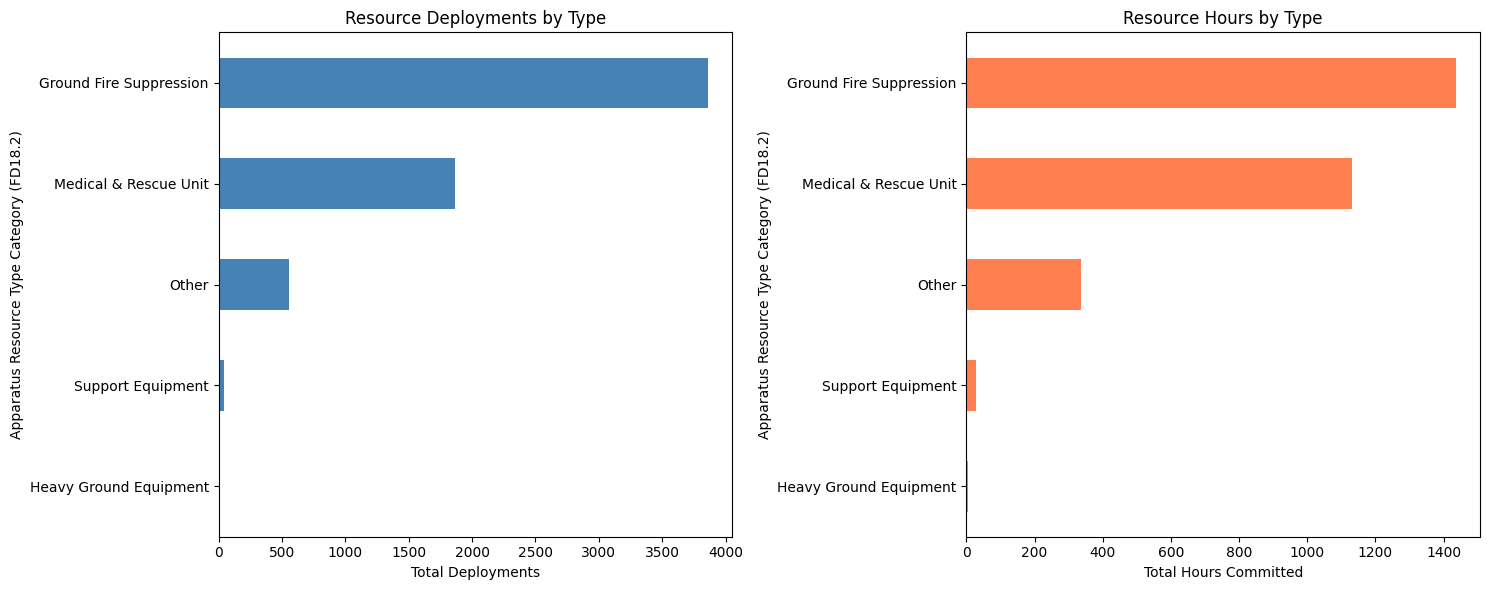

In [113]:
fire_example_df["clear_time"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Clear Date Time (FD18.5)"], 
    errors="coerce"
)
fire_example_df["arrival_time"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Arrival Date Time (FD18.4)"], 
    errors="coerce"
)

fire_example_df["on_scene_time"] = (
    fire_example_df["clear_time"] - fire_example_df["arrival_time"]
).dt.total_seconds() / 60

resource_stats = (
    fire_example_df.groupby("Apparatus Resource Type Category (FD18.2)")
    .agg({
        "Apparatus Resource ID (FD18.1)": "count", "on_scene_time": "sum"
    })
    .rename(columns={"Apparatus Resource ID (FD18.1)": "deployment_total","on_scene_time": "hours_total"})
)


resource_stats.dropna(inplace=True)
resource_stats["hours_total"] = resource_stats["hours_total"] / 60
resource_stats = resource_stats.sort_values("deployment_total", ascending=False)

print("\nResource Utilization:")
print(resource_stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

resource_stats["deployment_total"].plot(kind="barh", ax=ax1, color="steelblue")
ax1.set_xlabel("Total Deployments")
ax1.set_title("Resource Deployments by Type")
ax1.invert_yaxis()

resource_stats["hours_total"].plot(kind="barh", ax=ax2, color="coral")
ax2.set_xlabel("Total Hours Committed")
ax2.set_title("Resource Hours by Type")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


### Peak Hour Analysis


 Peak Hour Analysis 

Mean incidents per hour: 264.58
Median incidents per hour: 282.50
Std deviation: 108.90

Peak hour: 11:00 with 431 incidents
Lowest hour: 3:00 with 93 incidents

Top 5 busiest hours:
  11:00 - 431 incidents (6.8%)
  13:00 - 422 incidents (6.6%)
  19:00 - 400 incidents (6.3%)
  20:00 - 390 incidents (6.1%)
  12:00 - 355 incidents (5.6%)

Bottom 5 quietest hours:
  3:00 - 93 incidents (1.5%)
  4:00 - 99 incidents (1.6%)
  5:00 - 103 incidents (1.6%)
  1:00 - 148 incidents (2.3%)
  0:00 - 163 incidents (2.6%)

 Time Period Distribution 

Overnight (11pm-6am): 934 incidents (14.7%)
Morning rush (6am-10am): 1009 incidents (15.9%)
Midday (10am-2pm): 1550 incidents (24.4%)
Afternoon rush (2pm-6pm): 1323 incidents (20.8%)
Evening (6pm-11pm): 1534 incidents (24.2%)


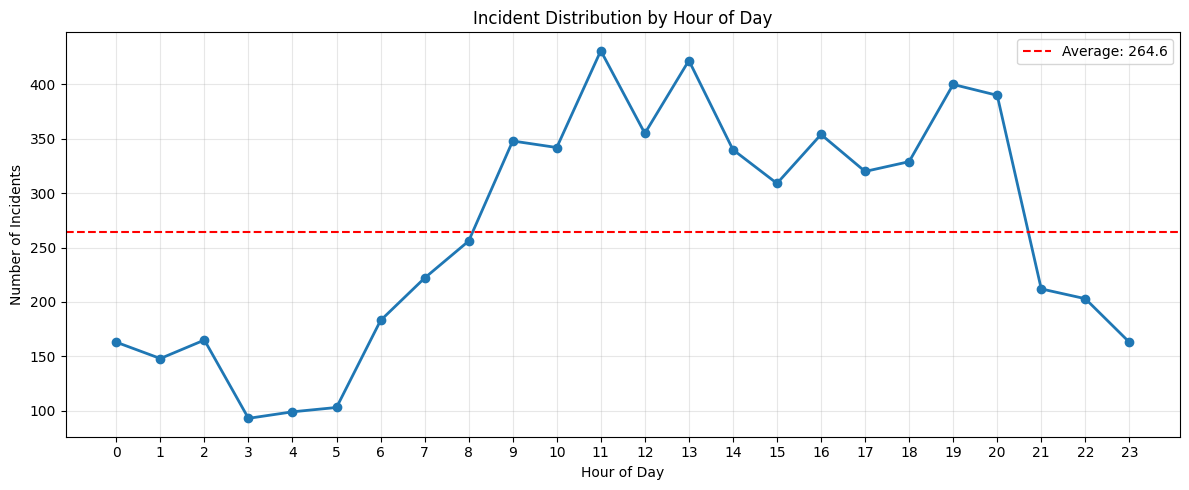

In [114]:

fire_example_df["dispatch_dt"] = pd.to_datetime(
    fire_example_df["Apparatus Resource Dispatch Date Time (FD18.3)"], 
    errors="coerce"
)
fire_example_df["hour"] = fire_example_df["dispatch_dt"].dt.hour

hourly_incidents = fire_example_df.groupby("hour").size()

print("\n Peak Hour Analysis \n")
print(f"Mean incidents per hour: {hourly_incidents.mean():.2f}")
print(f"Median incidents per hour: {hourly_incidents.median():.2f}")
print(f"Std deviation: {hourly_incidents.std():.2f}")
print(f"\nPeak hour: {hourly_incidents.idxmax()}:00 with {hourly_incidents.max()} incidents")
print(f"Lowest hour: {hourly_incidents.idxmin()}:00 with {hourly_incidents.min()} incidents")


print(f"\nTop 5 busiest hours:")

for hour, count in hourly_incidents.sort_values(ascending=False).head(5).items():
    print(f"  {hour}:00 - {count} incidents ({count/hourly_incidents.sum()*100:.1f}%)")
    
    
print(f"\nBottom 5 quietest hours:")
for hour, count in hourly_incidents.sort_values(ascending=True).head(5).items():
    print(f"  {hour}:00 - {count} incidents ({count/hourly_incidents.sum()*100:.1f}%)")


morning_rush = hourly_incidents[6:10].sum() #6 to 10am
midday = hourly_incidents[10:14].sum() #10am to 2pm
afternoon_rush = hourly_incidents[14:18].sum() #2pm to 6pm
evening = hourly_incidents[18:23].sum() #6pm to 11pm
overnight = hourly_incidents[list(range(0,6)) + [23]].sum() #11pm to 6am

print(f"\n Time Period Distribution \n")
print(f"Overnight (11pm-6am): {overnight} incidents ({overnight/hourly_incidents.sum()*100:.1f}%)")
print(f"Morning rush (6am-10am): {morning_rush} incidents ({morning_rush/hourly_incidents.sum()*100:.1f}%)")
print(f"Midday (10am-2pm): {midday} incidents ({midday/hourly_incidents.sum()*100:.1f}%)")
print(f"Afternoon rush (2pm-6pm): {afternoon_rush} incidents ({afternoon_rush/hourly_incidents.sum()*100:.1f}%)")
print(f"Evening (6pm-11pm): {evening} incidents ({evening/hourly_incidents.sum()*100:.1f}%)")

plt.figure(figsize=(12, 5))
plt.plot(hourly_incidents.index, hourly_incidents.values, marker='o', linewidth=2, markersize=6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Incidents")
plt.title("Incident Distribution by Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.axhline(y=hourly_incidents.mean(), color='r', linestyle='--', label=f'Average: {hourly_incidents.mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

#### Response By Postal Code Analysis


 Geographic Response Analysis by Postal Code 

                                     Incidents  Avg Response (min)
Basic Incident Postal Code (FD1.19)                               
85251                                     1215                6.35
85260                                     1170                6.28
85257                                      819                6.66
85255                                      810                8.90
85258                                      562                6.94
85259                                      404                7.92
85250                                      292                7.96
85262                                      254               10.66
85266                                      233                9.56
85254                                      219                7.60
85253                                      144                8.77
85018                                       55                8.55
85288         

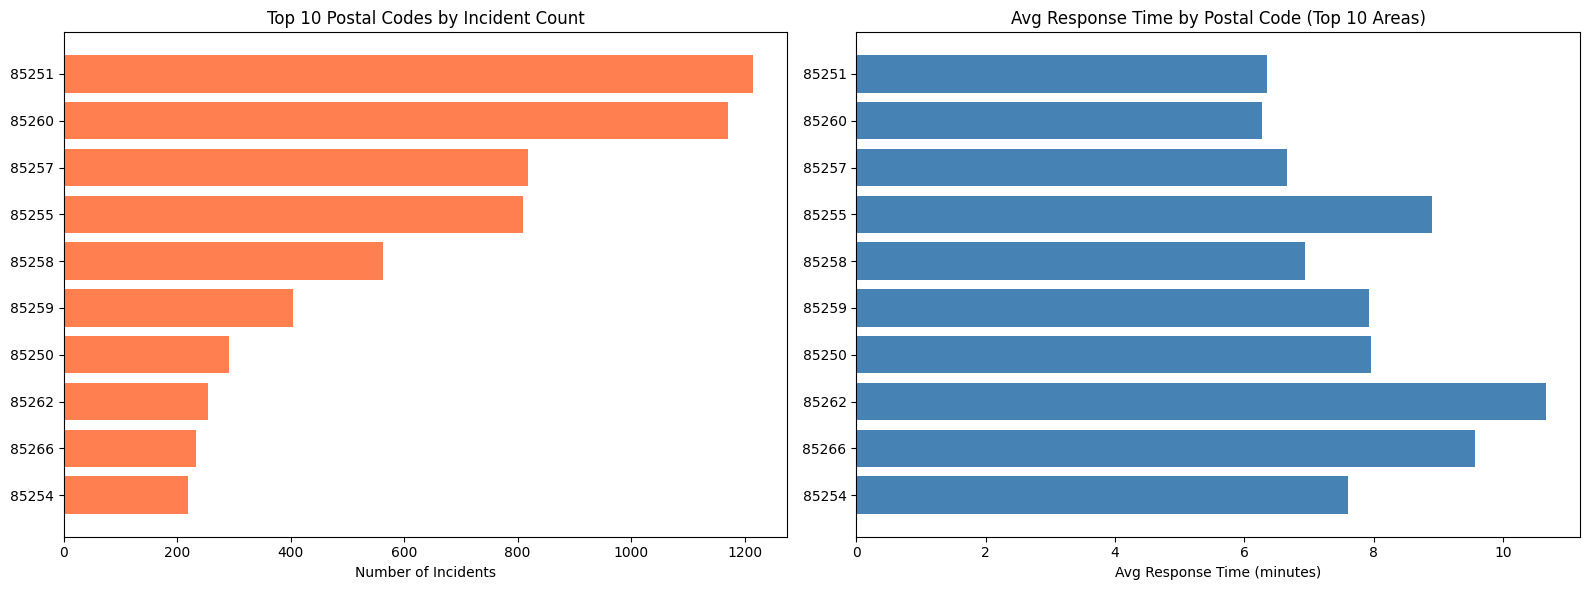

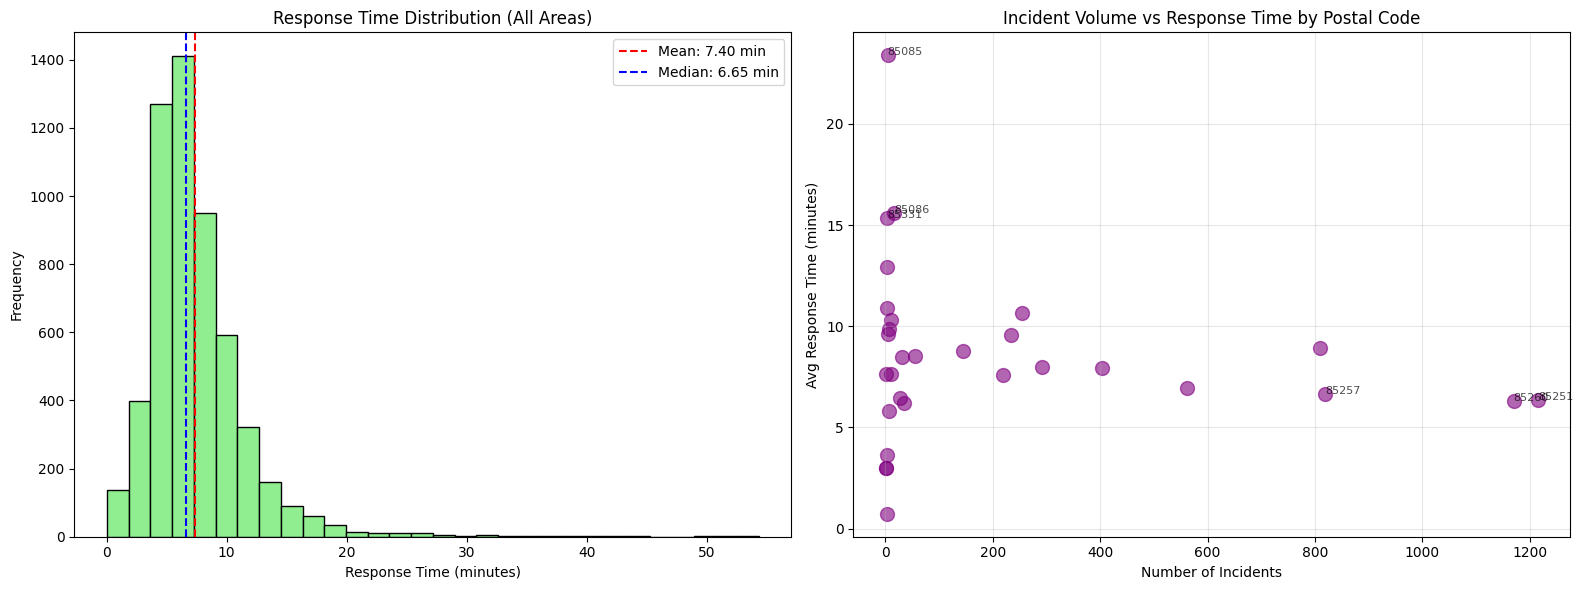


 Geographic Response Summary 

                             Metric    Value
   Total unique postal codes served    30.00
Overall average response time (min)     8.55
         Fastest avg response (min)     0.73
       Fastest response postal code 85031.00
         Slowest avg response (min)    23.39
       Slowest response postal code 85085.00


In [115]:
geo_analysis = fire_example_df[
    fire_example_df['Basic Incident Postal Code (FD1.19)'].notna() &
    (fire_example_df['Basic Incident Postal Code (FD1.19)'] != '')
].copy()

geo_analysis['dispatch_time'] = pd.to_datetime(
    geo_analysis['Apparatus Resource Dispatch Date Time (FD18.3)'], 
    errors='coerce'
)
geo_analysis['arrival_time'] = pd.to_datetime(
    geo_analysis['Apparatus Resource Arrival Date Time (FD18.4)'], 
    errors='coerce'
)
geo_analysis['response_minutes'] = (
    geo_analysis['arrival_time'] - geo_analysis['dispatch_time']
).dt.total_seconds() / 60

postal_stats = geo_analysis.groupby('Basic Incident Postal Code (FD1.19)').agg({
    'Basic Incident Number (FD1)': 'count',
    'response_minutes': 'mean'
}).rename(columns={
    'Basic Incident Number (FD1)': 'incident_count',
    'response_minutes': 'avg_response_time'
}).sort_values('incident_count', ascending=False)

postal_stats = postal_stats[postal_stats['avg_response_time'].notna()]




print("\n Geographic Response Analysis by Postal Code \n")
postal_display = postal_stats.head(15).copy()
postal_display['avg_response_time'] = postal_display['avg_response_time'].round(2)
postal_display.columns = ['Incidents', 'Avg Response (min)']
print(postal_display)




fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))

top_postal_codes = postal_stats.head(10)
axes1[0].barh(range(len(top_postal_codes)), top_postal_codes['incident_count'].values, color='coral')
axes1[0].set_yticks(range(len(top_postal_codes)))
axes1[0].set_yticklabels(top_postal_codes.index)
axes1[0].set_xlabel("Number of Incidents")
axes1[0].set_title("Top 10 Postal Codes by Incident Count")
axes1[0].invert_yaxis()

axes1[1].barh(range(len(top_postal_codes)), top_postal_codes['avg_response_time'].values, color='steelblue')
axes1[1].set_yticks(range(len(top_postal_codes)))
axes1[1].set_yticklabels(top_postal_codes.index)
axes1[1].set_xlabel("Avg Response Time (minutes)")
axes1[1].set_title("Avg Response Time by Postal Code (Top 10 Areas)")
axes1[1].invert_yaxis()

plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))

response_times_valid = geo_analysis['response_minutes'].dropna()
response_times_valid = response_times_valid[
    (response_times_valid > 0) & (response_times_valid < 60)
]



axes2[0].hist(response_times_valid, bins=30, color='lightgreen', edgecolor='black')
axes2[0].axvline(response_times_valid.mean(), color='red', linestyle='--', 
                label=f'Mean: {response_times_valid.mean():.2f} min')
axes2[0].axvline(response_times_valid.median(), color='blue', linestyle='--', 
                label=f'Median: {response_times_valid.median():.2f} min')
axes2[0].set_xlabel("Response Time (minutes)")
axes2[0].set_ylabel("Frequency")
axes2[0].set_title("Response Time Distribution (All Areas)")
axes2[0].legend()

axes2[1].scatter(postal_stats['incident_count'], 
               postal_stats['avg_response_time'], 
               alpha=0.6, s=100, color='purple')
axes2[1].set_xlabel("Number of Incidents")
axes2[1].set_ylabel("Avg Response Time (minutes)")
axes2[1].set_title("Incident Volume vs Response Time by Postal Code")
axes2[1].grid(True, alpha=0.3)

for idx, row in postal_stats.iterrows():
    if row['incident_count'] > postal_stats['incident_count'].quantile(0.9) or \
       row['avg_response_time'] > postal_stats['avg_response_time'].quantile(0.9):
        axes2[1].annotate(idx, 
                           (row['incident_count'], row['avg_response_time']),
                           fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\n Geographic Response Summary \n")
summary_data = {
    'Metric': [
        'Total unique postal codes served',
        'Overall average response time (min)',
        'Fastest avg response (min)',
        'Fastest response postal code',
        'Slowest avg response (min)',
        'Slowest response postal code'
    ],
    'Value': [
        len(postal_stats),
        round(postal_stats['avg_response_time'].mean(), 2),
        round(postal_stats['avg_response_time'].min(), 2),
        postal_stats['avg_response_time'].idxmin(),
        round(postal_stats['avg_response_time'].max(), 2),
        postal_stats['avg_response_time'].idxmax()
    ]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

### Additional EMS Stats

EMS Unit Analysis (Top 10)
                                            Total Calls  Transported  \
Response EMS Unit Call Sign (eResponse.14)                             
R602                                                225          210   
R608                                                209          199   
E601                                                208          121   
E602                                                157           77   
E605                                                151           70   
E609                                                144           66   
LT608                                               141           50   
L611                                                136           70   
E604                                                124           74   
LA601                                               115           49   

                                            Transport Rate (%)  \
Response EMS Unit Call Sign (eResponse.14)

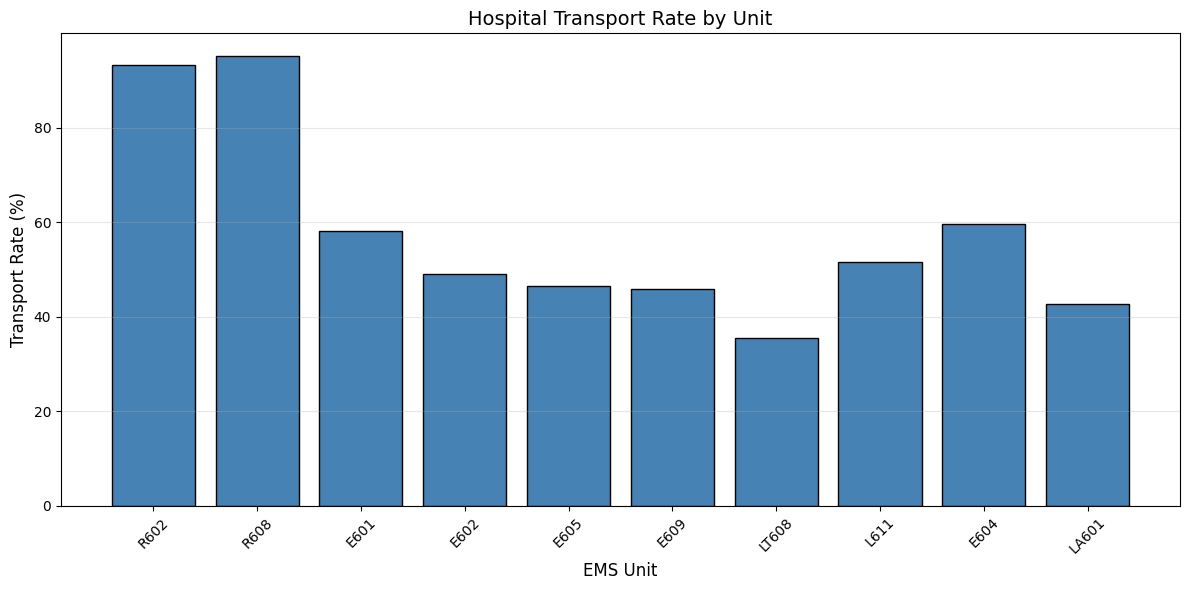

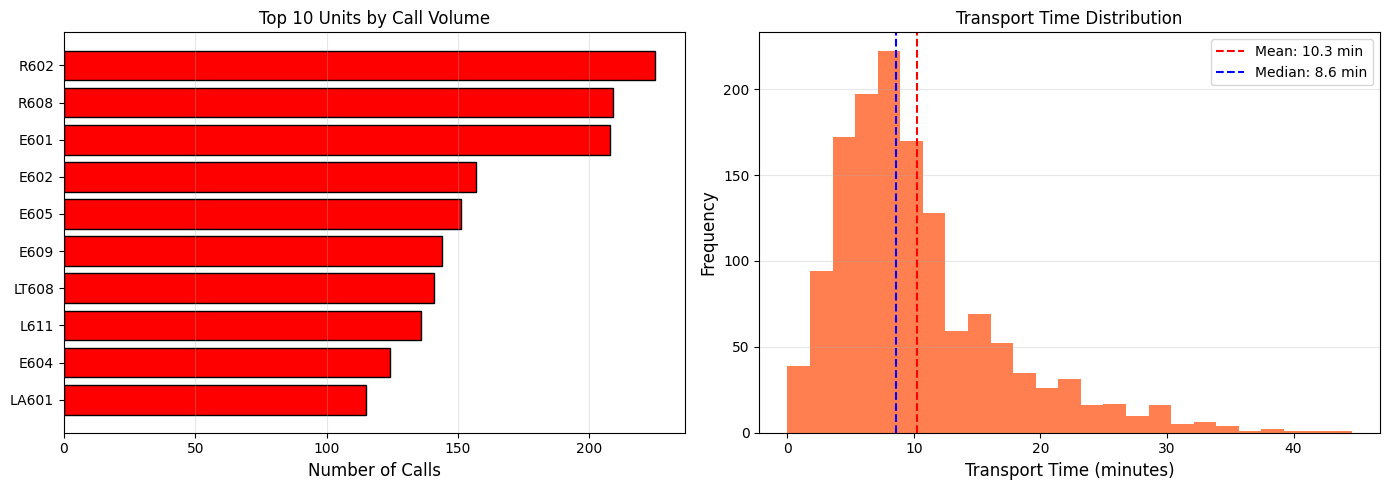

Additional Insights
Transport Rate
1,375 of 2,369 calls transported (58.0%)

Busiest Unit
R602: 225 calls (9.5% of total)


In [116]:
ems_example_df['left_scene_time'] = pd.to_datetime(
    ems_example_df['Incident Unit Left Scene Date Time (eTimes.09)'], 
    errors='coerce'
)
ems_example_df['hospital_arrival_time'] = pd.to_datetime(
    ems_example_df['Incident Patient Arrived At Destination Date Time (eTimes.11)'], 
    errors='coerce'
)

ems_example_df['transport_time'] = (
    ems_example_df['hospital_arrival_time'] - ems_example_df['left_scene_time']
).dt.total_seconds() / 60
ems_example_df['was_transported'] = ems_example_df['hospital_arrival_time'].notna()


unit_stats = ems_example_df.groupby('Response EMS Unit Call Sign (eResponse.14)').agg({
    'Response Incident Number (eResponse.03)': 'count',
    'was_transported': 'sum',
    'transport_time': 'mean'
}).rename(columns={
    'Response Incident Number (eResponse.03)': 'Total Calls',
    'was_transported': 'Transported',
    'transport_time': 'Avg Transport Time (min)'
}).sort_values('Total Calls', ascending=False).head(10)
unit_stats['Transport Rate (%)'] = (unit_stats['Transported'] / unit_stats['Total Calls'] * 100).round(1)
unit_stats['Avg Transport Time (min)'] = unit_stats['Avg Transport Time (min)'].round(2)




print("EMS Unit Analysis (Top 10)")
print(unit_stats[['Total Calls', 'Transported', 'Transport Rate (%)', 'Avg Transport Time (min)']])

fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(unit_stats.index, unit_stats['Transport Rate (%)'], color='steelblue', edgecolor='black')
ax1.set_xlabel('EMS Unit', fontsize=12)
ax1.set_ylabel('Transport Rate (%)', fontsize=12)
ax1.set_title('Hospital Transport Rate by Unit', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(14, 5))



top_units = unit_stats.head(10)
ax2.barh(range(len(top_units)), top_units['Total Calls'].values, color='red', edgecolor='black')
ax2.set_yticks(range(len(top_units)))
ax2.set_yticklabels(top_units.index)
ax2.set_xlabel('Number of Calls', fontsize=12)
ax2.set_title('Top 10 Units by Call Volume', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

transport_times = ems_example_df['transport_time'].dropna()
transport_times = transport_times[(transport_times > 0) & (transport_times < 60)]
ax3.hist(transport_times, bins=25, color='coral')
ax3.axvline(transport_times.mean(), color='red', linestyle='--', label=f'Mean: {transport_times.mean():.1f} min')
ax3.axvline(transport_times.median(), color='blue', linestyle='--', label=f'Median: {transport_times.median():.1f} min')
ax3.set_xlabel('Transport Time (minutes)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Transport Time Distribution', fontsize=12)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

total = len(ems_example_df)
transported = ems_example_df['was_transported'].sum()
transport_rate = transported / total * 100
busiest_unit = unit_stats.index[0]
busiest_unit_calls = unit_stats['Total Calls'].values[0]
busiest_unit_pct = busiest_unit_calls / total * 100

print("Additional Insights")
print(f"Transport Rate")
print(f"{transported:,} of {total:,} calls transported ({transport_rate:.1f}%)\n")

print(f"Busiest Unit")
print(f"{busiest_unit}: {busiest_unit_calls:,} calls ({busiest_unit_pct:.1f}% of total)")